In [40]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt

import os
from PIL import Image
from pathlib import Path
import csv

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

import tensorflow
import librosa.display

In [41]:
song_name = f'../Project-for-machine-learning/archive/genres/blues/blues.00000.au'
y, sr = librosa.load(song_name, mono=True, duration=2, offset=0)
#The IDE is telling me that "feature" is old, but it isn't
#Newest library source: https://librosa.org/doc/0.10.2/generated/librosa.feature.melspectrogram.html#librosa.feature.melspectrogram
ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
ps = librosa.power_to_db(ps**2)
ps.shape

(128, 173)

In [42]:
dataset = []
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
        'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

for genre, genre_number in genres.items():
    for filename in os.listdir(f'../Project-for-machine-learning/archive/genres/{genre}'):
        song_name = f'../Project-for-machine-learning/archive/genres/{genre}/{filename}'
        for index in range(14):
            y, sr = librosa.load(song_name, mono=True, duration=2, offset=index*2)
            
            ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=64)
            ps = librosa.power_to_db(ps**2)
            dataset.append( (ps, genre_number) )

In [43]:
print(len(dataset))

14000


In [44]:
import random

random.shuffle(dataset)

train = dataset[:10000]
valid = dataset[10000:12000]
test = dataset[12000:]

X_train, Y_train = zip(*train)
X_valid, Y_valid = zip(*valid)
X_test, Y_test = zip(*test)

# Reshape for CNN input
X_train = np.array([x.reshape( (64, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (64, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (64, 173, 1) ) for x in X_test])

# One-Hot encoding for classes
Y_train = np.array(tensorflow.keras.utils.to_categorical(Y_train, 10))
Y_valid = np.array(tensorflow.keras.utils.to_categorical(Y_valid, 10))
Y_test = np.array(tensorflow.keras.utils.to_categorical(Y_test, 10))

In [45]:
import tensorflow as tf


In [46]:
!pip install transformers

In [47]:
from tensorflow.keras import Input

len(X_train)
X_train.shape
n_features = X_train.shape[2]
input_shape = (None, X_train.shape[1])
print(input_shape)
model_input = Input(input_shape, name='input')
print(model_input)
X_train.shape

(None, 64)
<KerasTensor shape=(None, None, 64), dtype=float32, sparse=False, name=input>


(10000, 64, 173, 1)

In [61]:
# Flatten the spectrogram data to 1D arrays
'''X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)'''


'X_train_flat = X_train.reshape(X_train.shape[0], -1)\nX_valid_flat = X_valid.reshape(X_valid.shape[0], -1)\nX_test_flat = X_test.reshape(X_test.shape[0], -1)'

In [72]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import l2

model = Sequential()
# First Conv Block
model.add(Conv2D(16, (5, 5), input_shape=(64, 173, 1), activation="relu", padding="valid", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Second Conv Block
model.add(Conv2D(32, (5, 5), activation="relu", kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
# Fully Connected Layers
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(128, activation="relu", kernel_regularizer=l2(0.001)))
model.add(Dropout(0.4))
model.add(Dense(10, activation="softmax"))
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 60, 169, 16)    │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 60, 169, 16)    │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 30, 84, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 80, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 26, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 13, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16640)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 16640)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 128)            │     2,130,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,144,778 (8.18 MB)

 Trainable params: 2,144,682 (8.18 MB)

 Non-trainable params: 96 (384.00 B)

In [69]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate = 1e-5), loss="categorical_crossentropy", metrics=['accuracy'])

In [70]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=2)
history = model.fit(X_train, Y_train, epochs=40, batch_size=64, validation_data=(X_valid, Y_valid), callbacks=[early_stopping])


# My pc can't run that many epochs (╥﹏╥)
# Hopefully I get a better one ( ◡̀_◡́)ᕤ

Epoch 1/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.6399 - loss: 1.3015 - val_accuracy: 0.6255 - val_loss: 1.3606
Epoch 2/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 154ms/step - accuracy: 0.6488 - loss: 1.2718 - val_accuracy: 0.6260 - val_loss: 1.3631
Epoch 3/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - accuracy: 0.6548 - loss: 1.2757 - val_accuracy: 0.6295 - val_loss: 1.3650
Epoch 4/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 159ms/step - accuracy: 0.6506 - loss: 1.2671 - val_accuracy: 0.6430 - val_loss: 1.3432
Epoch 5/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.6652 - loss: 1.2155 - val_accuracy: 0.6305 - val_loss: 1.3458
Epoch 6/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.6673 - loss: 1.2086 - val_accuracy: 0.6365 - val_loss: 1.3315
Epoch 7/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.6830 - loss: 1.1807 - val_accuracy: 0.6395 - val_loss: 1.3213
Epoch 8/40
157/157 ━━━━━━━━━━━━━━━━━━━━ 26s 167ms/step - accuracy: 0.6680 - loss: 1

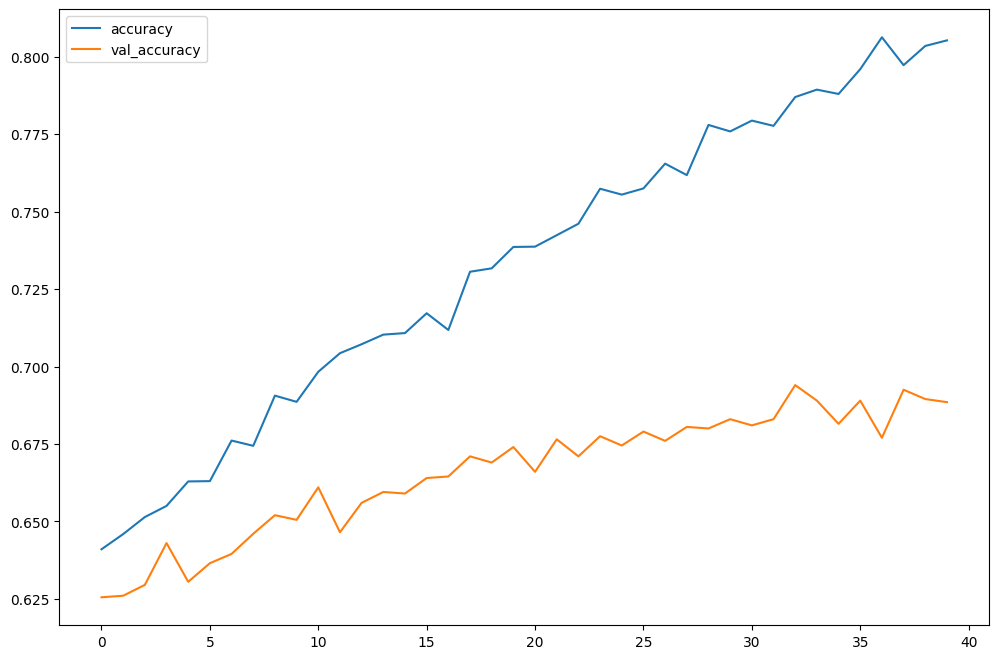

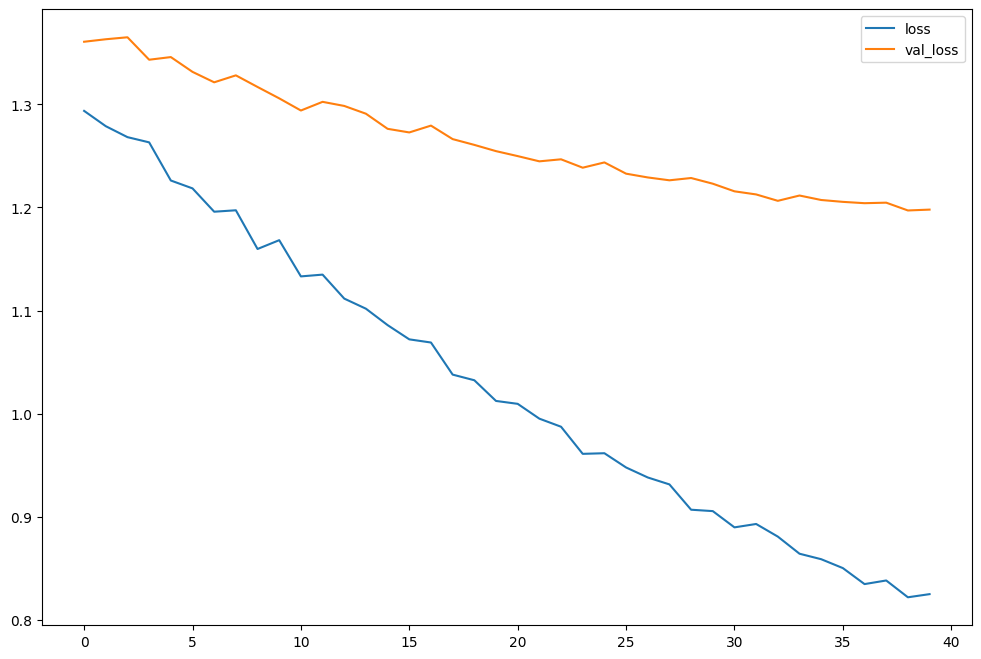

313/313 - 8s - 27ms/step - accuracy: 0.9633 - loss: 0.4807
63/63 - 2s - 26ms/step - accuracy: 0.6925 - loss: 1.1665
Training accuracy: 0.9632999897003174
Test accuracy: 0.6924999952316284


In [71]:
plt.figure(figsize=(12,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.show()
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose = 2)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose = 2)
print('Training accuracy:', train_acc)
print('Test accuracy:', test_acc)